In [ ]:
# Run this codeblock to mount your Google Drive in Google Colab.
from google.colab import drive

drive.mount("/content/drive/")

In [3]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch

ROOT = "./"  # TODO: set your root directory here
# ROOT = '/content/drive/MyDrive/cosmos' # example for Google Drive

ROOT = Path(ROOT)
# Check if the root directory exists
if not ROOT.exists():
    print(f"Root directory {ROOT} does not exist. Please check the path.")

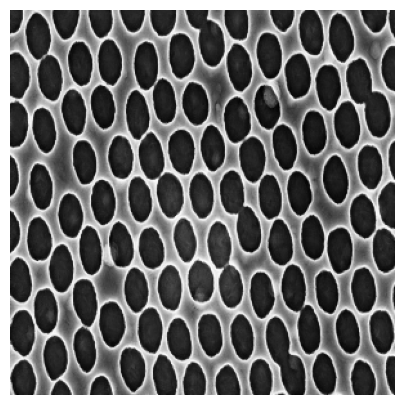

In [4]:
img = np.load(ROOT / "img.npy")
img = torch.tensor(img, dtype=torch.float32)
plt.figure(figsize=(5, 5))
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.show()

In [3]:
def dipole_kernel(
    matrix_size: tuple[int, int],
    voxel_size: tuple[float, float] = (1.0, 1.0),
    B0_dir: tuple[float, float] = (0.0, 1.0),
) -> torch.Tensor:
    y = np.arange(-matrix_size[1] / 2, matrix_size[1] / 2, 1)
    x = np.arange(-matrix_size[0] / 2, matrix_size[0] / 2, 1)
    Y, X = np.meshgrid(y, x)

    X = X / (matrix_size[0] * voxel_size[0])
    Y = Y / (matrix_size[1] * voxel_size[1])

    D = 1 / 3 - (X * B0_dir[0] + Y * B0_dir[1]) ** 2 / (X**2 + Y**2 + 1e-8)
    D = np.fft.fftshift(D)
    D = torch.tensor(D, dtype=torch.float32)
    return D

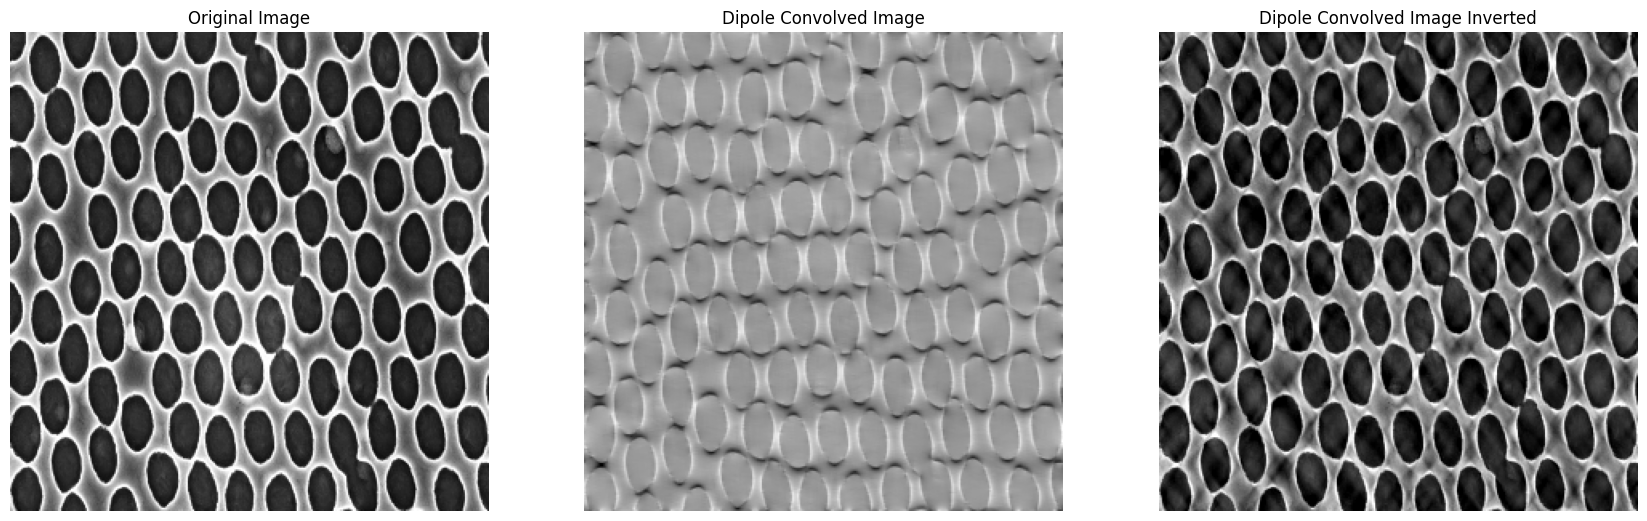

In [4]:
img_shape = img.shape
kernel = dipole_kernel(
    matrix_size=(img_shape[1], img_shape[0]), voxel_size=(1.0, 1.0), B0_dir=(1.0, 0.0)
)

img_k = torch.fft.fftn(img, dim=(-2, -1))
img_dipole = torch.fft.ifftn(img_k * kernel, dim=(-2, -1)).real

kernel_inv = 1 / kernel
kernel_inv = torch.clip(kernel_inv, min=-5, max=5)

img_dipole_k = torch.fft.fftn(img_dipole, dim=(-2, -1))
img_dipole_inv = torch.fft.ifftn(img_dipole_k * kernel_inv, dim=(-2, -1)).real

vmax_label = np.percentile(img, 98) * 1.0
vmin = 0

plt.figure(figsize=(21, 7))
plt.subplot(1, 3, 1)
plt.imshow(img, cmap="gray", vmin=vmin, vmax=vmax_label)
plt.title("Original Image")
plt.axis("off")
plt.subplot(1, 3, 2)
plt.imshow(img_dipole, cmap="gray")
plt.title("Dipole Convolved Image")
plt.axis("off")
plt.subplot(1, 3, 3)
plt.imshow(img_dipole_inv, cmap="gray", vmin=vmin, vmax=vmax_label)
plt.title("Dipole Convolved Image Inverted")
plt.axis("off")
plt.show()